### Predict severity of service disruptions on Telestra Network
> Nature of dataset : Service Logs.
> Predict whether disruption is a momentary glitch or a total interruption of activity.
> Telestra is putting efforts into predicting timing and scope of such disruptions.

### Objective

The goal of the problem is to predict Telstra network's _fault severity_ at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the __id__ column, which is the key __id__ used in other data files. 

Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). 

Different types of features are extracted from log files and other sources: event_type.csv, log_feature.csv, resource_type.csv, severity_type.csv. 

Note: __severity_type__ is a feature extracted from the log files (in severity_type.csv). Often this is a severity type of a warning message coming from the log. __severity_type__ is categorical. It does not have an ordering. __fault_severity__ is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

** File Descriptions **

* train.csv - the training set for fault severity
* test.csv - the test set for fault severity
* sample_submission.csv - a sample submission file in the correct format
* event_type.csv - event type related to the main dataset
* log_feature.csv - features extracted from log files
* resource_type.csv - type of resource related to the main dataset
* severity_type.csv -  severity type of a warning message coming from the log

** Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). **

In [1]:
%matplotlib inline
from __future__ import division

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

C:\Users\Abhishek\Anaconda2\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
C:\Users\Abhishek\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


** Preprocessing**

In [2]:
def str_to_num(string):
    return int(string.split()[1])

In [3]:
# load train and test files
train = pd.read_csv('../data/train.csv', converters={'location': str_to_num})
test = pd.read_csv('../data/test.csv', converters={'location': str_to_num})

In [4]:
train.head()

,id,location,fault_severity
0,14121,118,1
1,9320,91,0
2,14394,152,1
3,8218,931,1
4,14804,120,0


** Each row is uniquely represented by an `id` and represent time and location **

In [5]:
test.head()

,id,location
0,11066,481
1,18000,962
2,16964,491
3,4795,532
4,3392,600


### Concatenate Train and Test Dataframes

In [6]:
data = pd.concat([train, test], axis=0)

### Class Balance

In [146]:
train.fault_severity.value_counts()

0    4784
1    1871
2     726
Name: fault_severity, dtype: int64

** There is a class imbalance which should be kept into consideration. **

In [7]:
# load other files

event_types = pd.read_csv('../data/event_type.csv', converters={'event_type': str_to_num})
log_features = pd.read_csv('../data/log_feature.csv', converters={'log_feature': str_to_num})
resource_types = pd.read_csv('../data/resource_type.csv', converters={'resource_type': str_to_num})
severity_types = pd.read_csv('../data/severity_type.csv', converters={'severity_type': str_to_num})

In [9]:
event_types.head()

,id,event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,15
4,5022,11


** How many different types of event types are present in the dataset ? **

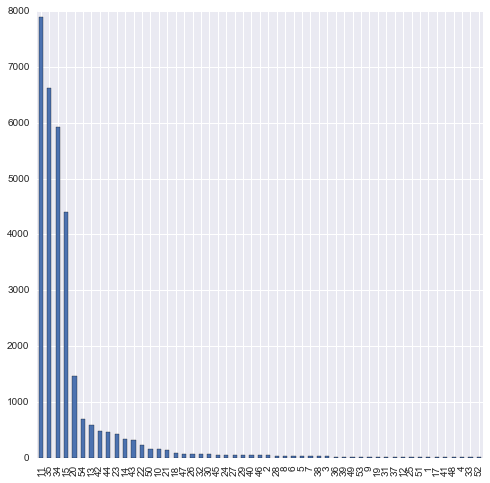

In [149]:
plt.figure(figsize=(8, 8))
event_types.event_type.value_counts().plot(kind='bar');

** Some event types are most common and rest occur less frequently. **

** Is there any relationship between event types and the ids ? **

In [150]:
g = event_types.groupby('id').size()
g.describe()

count    18552.000000
mean         1.680142
std          0.716816
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         11.000000
dtype: float64

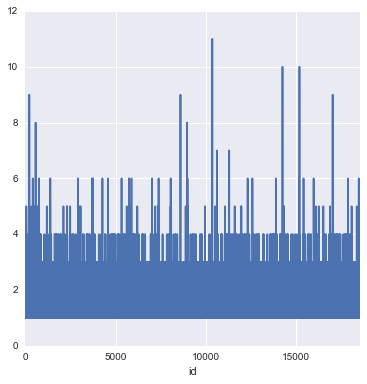

In [151]:
plt.figure(figsize=(6, 6))
g.plot();

** Most of the ids have 2 or 3 events registered against it but some have many events registered **

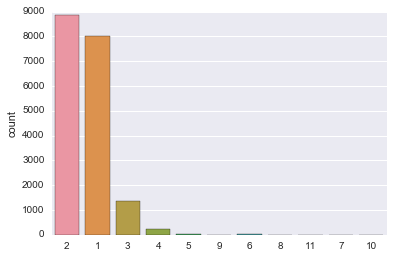

In [152]:
sns.countplot(g.values);

** Most of the ids have 1 or 2 event types associated with them **

In [153]:
log_features.head()

,id,log_feature,volume
0,6597,68,6
1,8011,68,7
2,2597,68,1
3,5022,172,2
4,5022,56,1


In [154]:
log_features.log_feature.value_counts()

312    5267
232    4754
82     3472
203    2823
313    2145
233    1901
307    1597
54     1573
170    1526
71     1514
315    1495
134    1419
80     1336
235    1294
193    1160
219    1152
68     1093
227    1080
314     950
201     902
234     882
73      868
195     783
301     707
309     627
55      564
229     560
273     491
308     484
368     462
       ... 
272       1
208       1
144       1
16        1
325       1
6         1
262       1
294       1
326       1
263       1
296       1
9         1
297       1
329       1
106       1
363       1
12        1
300       1
364       1
13        1
269       1
333       1
14        1
142       1
334       1
143       1
175       1
271       1
351       1
32        1
Name: log_feature, dtype: int64

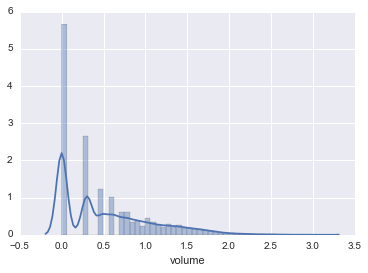

In [155]:
sns.distplot(log_features.volume.map(np.log10));

** Is there any relationship between id ( time, location ) with the log feature recorderd ? **

In [45]:
g = log_features.groupby(['id', 'log_feature']).size().unstack(1).fillna(0).apply(lambda x: np.count_nonzero(x), axis=1)

In [48]:
g.describe()

count    18552.000000
mean         3.162516
std          2.156997
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         20.000000
dtype: float64

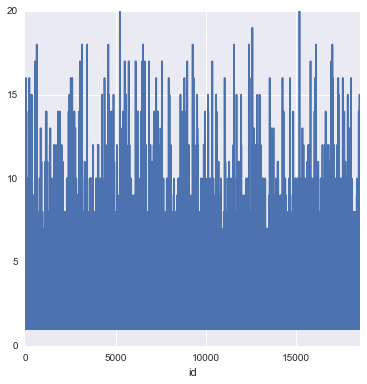

In [49]:
plt.figure(figsize=(6, 6))
g.plot();

In [156]:
resource_types.head()

,id,resource_type
0,6597,8
1,8011,8
2,2597,8
3,5022,8
4,6852,8


In [157]:
resource_types.resource_type.value_counts()

8     10268
2      8918
6       582
7       498
4       330
9       190
3       145
10       73
1        58
5        14
Name: resource_type, dtype: int64

In [55]:
g = resource_types.groupby(['id', 'resource_type']).size().unstack(1).fillna(0).apply(lambda x: np.count_nonzero(x), axis=1)

In [56]:
g.describe()

count    18552.00000
mean         1.13605
std          0.41211
min          1.00000
25%          1.00000
50%          1.00000
75%          1.00000
max          5.00000
dtype: float64

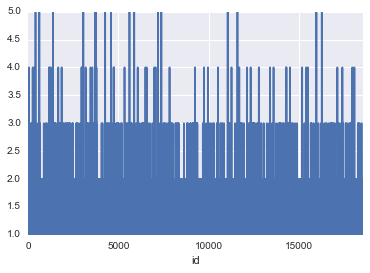

In [58]:
g.plot();

In [59]:
severity_types.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [60]:
severity_types.severity_type.value_counts()

severity_type 2    8737
severity_type 1    8728
severity_type 4    1014
severity_type 5      65
severity_type 3       8
Name: severity_type, dtype: int64

### Relationship between fault security and location

In [158]:
g = train.groupby(['fault_severity', 'location']).size().unstack(1).fillna(0)

In [159]:
g.apply(lambda x: np.max(x), axis=1)

fault_severity
0    69.0
1    27.0
2    33.0
dtype: float64

In [160]:
g.ix[0][g.ix[0] == 69.0]

location
126    69.0
Name: 0, dtype: float64

In [161]:
g.ix[1][g.ix[1] == 27.0]

location
821    27.0
Name: 1, dtype: float64

In [162]:
g.ix[2][g.ix[2] == 33.0]

location
1100    33.0
1107    33.0
Name: 2, dtype: float64

## Relationship between id ( time, location ) with fault severity

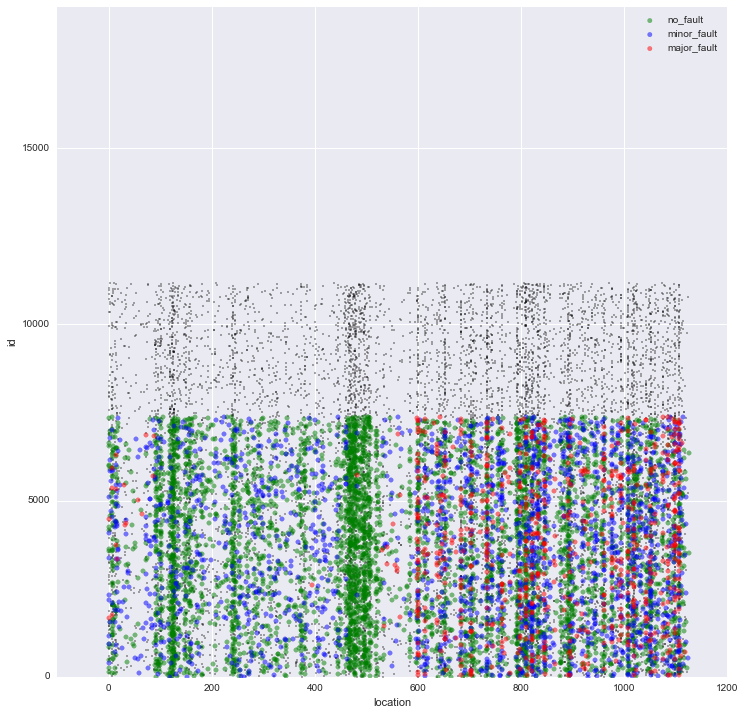

In [177]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(data.loc[data.fault_severity.isnull(), 'location'], data.loc[data.fault_severity.isnull()].index, alpha=0.5,\
           color='k', s=2)

ax.scatter(data.loc[data.fault_severity==0, 'location'], data.loc[data.fault_severity==0].index, alpha=0.5, color='g', label='no_fault')
ax.scatter(data.loc[data.fault_severity==1, 'location'], data.loc[data.fault_severity==1].index, alpha=0.5, color='b', label='minor_fault')
ax.scatter(data.loc[data.fault_severity==2, 'location'], data.loc[data.fault_severity==2].index, alpha=0.5, color='r', label='major_fault')
ax.set_xlim((-100,1200))
ax.set_ylim((0,19000))
ax.set_xlabel('location')
ax.set_ylabel('id')
ax.legend(loc='best');

## Relationship between event types and fault severity

In [178]:
event_types_merged = pd.merge(train, event_types, on='id', how='left')

In [179]:
c = pd.crosstab(event_types_merged.fault_severity, event_types_merged.event_type)

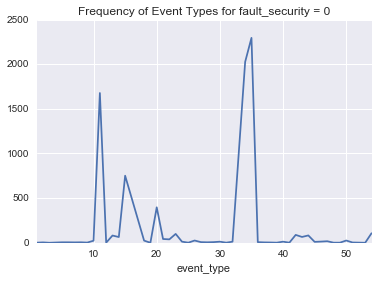

In [180]:
c.ix[0].plot()
plt.title('Frequency of Event Types for fault_security = 0');

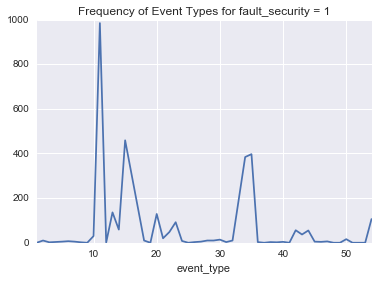

In [181]:
c.ix[1].plot()
plt.title('Frequency of Event Types for fault_security = 1');

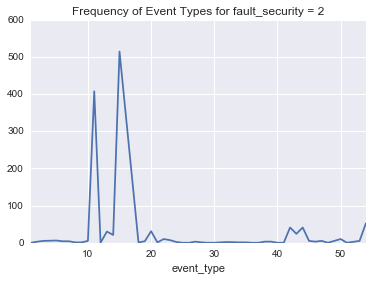

In [182]:
c.ix[2].plot()
plt.title('Frequency of Event Types for fault_security = 2');

## Relation between log features and fault severity

In [183]:
log_features_merged = pd.merge(train, log_features, on='id', how='left'); log_features_merged.head()

,id,location,fault_severity,log_feature,volume
0,14121,118,1,312,19
1,14121,118,1,232,19
2,9320,91,0,315,200
3,9320,91,0,235,116
4,14394,152,1,221,1


In [193]:
c = pd.crosstab(log_features_merged.fault_severity, log_features_merged.log_feature)

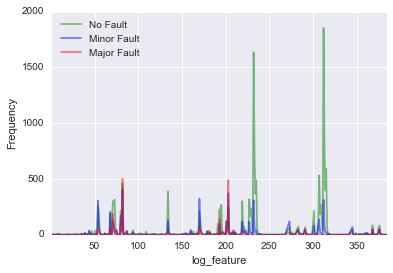

In [199]:
c.ix[0].plot(color='g', alpha=0.5, label='No Fault')
c.ix[1].plot(color='b', alpha=0.5, label='Minor Fault')
c.ix[2].plot(color='r', alpha=0.5, label='Major Fault')
plt.ylabel('Frequency')
plt.legend(loc='best');

In [216]:
p = log_features_merged.pivot_table(index='fault_severity', columns='log_feature', \
                                    values='volume', aggfunc=np.mean, fill_value=0)

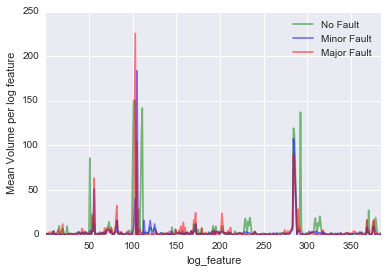

In [217]:
p.ix[0].plot(color='g', alpha=0.5, label='No Fault')
p.ix[1].plot(color='b', alpha=0.5, label='Minor Fault')
p.ix[2].plot(color='r', alpha=0.5, label='Major Fault');
plt.ylabel('Mean Volume per log feature')
plt.legend(loc='best');

### Relation between resource type and fault severity

In [218]:
resource_types_merged = pd.merge(train, resource_types, on='id', how='left'); resource_types_merged.head()

,id,location,fault_severity,resource_type
0,14121,118,1,2
1,9320,91,0,2
2,14394,152,1,2
3,8218,931,1,8
4,14804,120,0,2


In [220]:
c = pd.crosstab(resource_types_merged.fault_severity, resource_types_merged.resource_type)

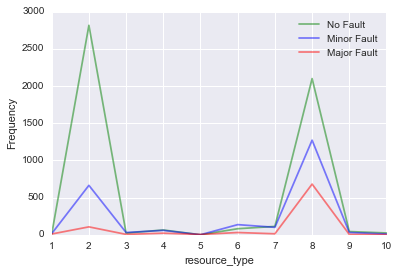

In [222]:
c.ix[0].plot(color='g', alpha=0.5, label='No Fault')
c.ix[1].plot(color='b', alpha=0.5, label='Minor Fault')
c.ix[2].plot(color='r', alpha=0.5, label='Major Fault')
plt.ylabel('Frequency')
plt.legend(loc='best');

## Merge location and event data